In [11]:
# 1. Import library
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)

In [12]:
# 2. Load fact_sales (hasil ETL Bab 2)
fact_sales = pd.read_csv("/content/fact_sales.csv")

In [13]:
# 3. Buat target variable (Churn Flag)
# Asumsi churn: customer tidak ada order lagi dalam 6 bulan terakhir
fact_sales['order_purchase_timestamp'] = pd.to_datetime(fact_sales['order_purchase_timestamp'])
last_date = fact_sales['order_purchase_timestamp'].max()

customer_last_order = (
    fact_sales.groupby("customer_id")['order_purchase_timestamp']
    .max()
    .reset_index()
)
customer_last_order['days_since_last_order'] = (
    last_date - customer_last_order['order_purchase_timestamp']
).dt.days
customer_last_order['churn'] = (
    customer_last_order['days_since_last_order'] > 180
).astype(int)

In [14]:
# 4. Buat fitur agregat per customer
agg_features = (
    fact_sales.groupby("customer_id").agg({
        "revenue": "sum",
        "order_id": "nunique",
        "payment_value": "sum",
        "review_score": "mean"
    }).reset_index()
)

# Handle missing values
agg_features = agg_features.fillna({
    "revenue": 0,
    "order_id": 0,
    "payment_value": 0,
    "review_score": 3.0  # netral rating
})

# Merge dengan churn flag
agg_features = agg_features.merge(
    customer_last_order[['customer_id', 'churn']],
    on="customer_id"
)

In [15]:
# 5. Split data train-test
X = agg_features.drop(columns=['customer_id', 'churn'])
y = agg_features['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
# 6. Scaling (hanya untuk model linear seperti Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# 7. Modeling Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:, 1]

In [18]:
# 9. Evaluasi kedua model
results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1": f1_score(y_test, y_pred_log),
    "ROC AUC": roc_auc_score(y_test, y_prob_log)
})

# Decision Tree
results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "ROC AUC": roc_auc_score(y_test, y_prob_dt)
})

results_df = pd.DataFrame(results)
print("\n📊 Perbandingan Model:\n", results_df)


📊 Perbandingan Model:
                  Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression  0.609101   0.609081  1.000000  0.757055  0.528685
1        Decision Tree  0.792490   0.827276  0.833264  0.830259  0.781277


In [19]:
# 8. Modeling Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train) # Using non-scaled data for Decision Tree

y_pred_dt = dt_clf.predict(X_test)
y_prob_dt = dt_clf.predict_proba(X_test)[:, 1]

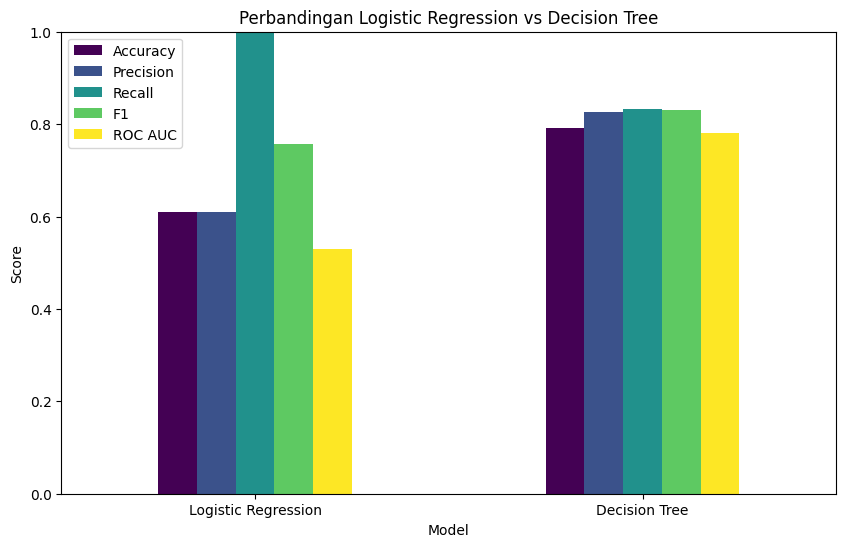

In [20]:
# 10. Visualisasi perbandingan
results_df.set_index("Model")[["Accuracy","Precision","Recall","F1","ROC AUC"]].plot(
    kind="bar", figsize=(10,6), rot=0, colormap="viridis"
)
plt.title("Perbandingan Logistic Regression vs Decision Tree")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

In [21]:
# 11. Kesimpulan singkat
best_model = results_df.sort_values(by="ROC AUC", ascending=False).iloc[0]
print(f"\n✅ Model terbaik berdasarkan ROC AUC adalah: {best_model['Model']} dengan skor {best_model['ROC AUC']:.3f}")


✅ Model terbaik berdasarkan ROC AUC adalah: Decision Tree dengan skor 0.781
